In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from skimage import io

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
19458,00005171_000.png,No Finding,0,5171,33,M,PA,2500,2048,0.171,0.171,NaN
102585,00027354_000.png,No Finding,0,27354,39,F,PA,2992,2991,0.143,0.143,NaN
78060,00019169_007.png,Atelectasis|Effusion|Infiltration,7,19169,57,F,AP,3056,2544,0.139,0.139,NaN
12797,00003361_005.png,Effusion,5,3361,52,F,AP,2500,2048,0.168,0.168,NaN
50578,00012829_012.png,No Finding,12,12829,55,M,AP,2500,2048,0.168,0.168,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5533,00030159_015.png,Atelectasis|Consolidation|Effusion|Mass,15,30159,038Y,M,AP,3056,2544,0.139,0.139
1509,00007870_002.png,No Finding,2,7870,050Y,M,PA,2992,2991,0.143,0.143
238,00001280_004.png,No Finding,4,1280,037Y,F,PA,2048,2500,0.168,0.168
5453,00029666_001.png,No Finding,1,29666,020Y,F,AP,3056,2544,0.139,0.139
3764,00018462_001.png,Atelectasis,1,18462,071Y,M,AP,2500,2048,0.168,0.168


***

# Exploratory data analysis  

1. [Exploring the metadata](#Exploring-the-metadata)
2. [Exploring the pixel-level data](#Exploring-the-pixel-level-data)
3. [Conclusion](#Conclusion)

## Exploring the metadata
***

#### Explore the dataframe

In [4]:
print("We have {} entries in the original dataset.".format(len(all_xray_df)))

We have 112120 entries in the original dataset.


In [5]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


The column "Unnamed: 11" seems suspicious. We can already see that it contains only null values. It is irrelevant for our analysis.

In [6]:
print("Number of non-null values in the column 'Unnamed: 11': ", all_xray_df["Unnamed: 11"].nunique())

Number of non-null values in the column 'Unnamed: 11':  0


The column with the label `Unnamed: 11` can be discarded.

In [7]:
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])

#### Exploring demographics
We can check the distribution of the following features in our dataset: 
* Age	 
* Gender

In [8]:
ages = all_xray_df["Patient Age"]

print("Average age: ", np.round(ages.mean(), decimals=2))
print("Median age: ", ages.median())
print("Oldest patient: ", ages.max())
print("Youngest patient: ", ages.min())

Average age:  46.9
Median age:  49.0
Oldest patient:  414
Youngest patient:  1


We can already see that there were probably errors made while entering the age data. We can explore the least frequent entries for the age column.

In [9]:
print('Least frequent entries for the age column:')
ages.value_counts().tail(15)

Least frequent entries for the age column:


94     8
92     6
412    3
148    2
155    2
149    1
150    1
151    1
153    1
154    1
411    1
413    1
414    1
95     1
152    1
Name: Patient Age, dtype: int64

> If we were using the age as a feature in our model, it would be necessary to remove the entries with the extreme values contained in the `Patient Age` column. Since we will be using only the image data to make our prediction, we don't need to do that.

In [10]:
ages_under100 = ages[ages<=100]
ages_over100 = ages[ages>100]
print("Number of entries with age > 100: ", len(ages_over100))

Number of entries with age > 100:  16


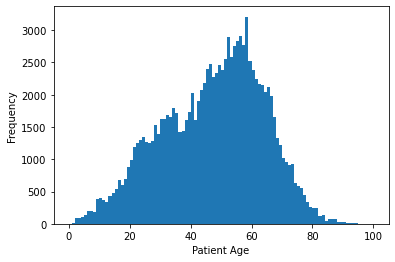

In [11]:
ages_under100.plot.hist(bins=100, range=(0, 100))
plt.xlabel('Patient Age');

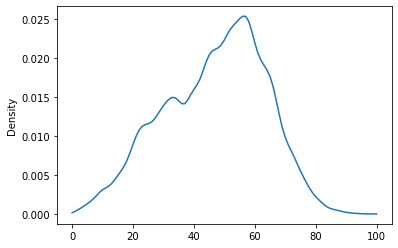

In [12]:
ages_under100.plot.kde(ind=np.arange(101));

In [13]:
round(len(ages[(ages>=18) & (ages<=80)])/len(ages_under100)*100)

95

> 95% of the subjects are between the ages of 18 and 80.

As we are interested in Pneumonia, let's see if the age distribution differs if we only consider patients diagnosted with Pneumonia.

In [14]:
pneumonia_df = all_xray_df[all_xray_df['Finding Labels'].apply(lambda x: 'Pneumonia' in x.split('|'))==1]

In [15]:
print("Number of entries with age > 100 and having Pneumonia: ", len(pneumonia_df[pneumonia_df['Patient Age']>100]))

Number of entries with age > 100 and having Pneumonia:  1


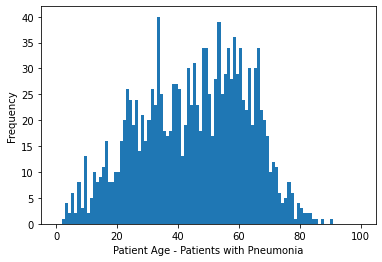

In [16]:
pneumonia_df[pneumonia_df['Patient Age']<=100]['Patient Age'].plot.hist(bins=100, range=(0, 100))
plt.xlabel('Patient Age - Patients with Pneumonia');

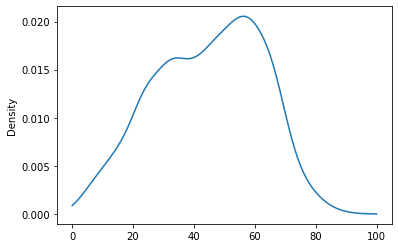

In [17]:
pneumonia_df[pneumonia_df['Patient Age']<=100]['Patient Age'].plot.kde(ind=np.arange(101))

> We note that both distributions are similar. We need to keep a similar distribution in the validation data to reflect the real world.

Let's move over to the remaining columns:
* `Patient Gender`
* `Follow-up #`
* `View Position`

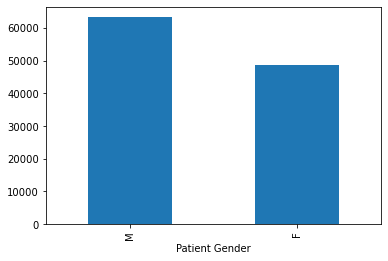

In [18]:
all_xray_df["Patient Gender"].value_counts().plot.bar()
plt.xlabel("Patient Gender");

In [19]:
m, f = np.round(all_xray_df["Patient Gender"].value_counts()/len(all_xray_df)*100, decimals=1).tolist()
print('Gender distribution')
print('Male: {}%'.format(m))
print('Female: {}%'.format(f))

Gender distribution
Male: 56.5%
Female: 43.5%


We can also explore the number of follow-ups.

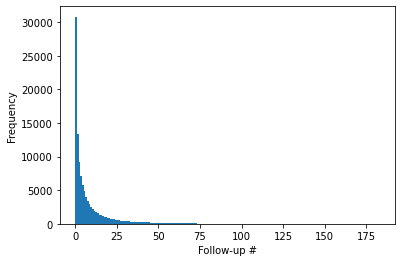

In [20]:
all_xray_df["Follow-up #"].plot.hist(bins=183, range=(0, 183))
plt.xlabel("Follow-up #");

In [21]:
np.round((all_xray_df["Follow-up #"]==0).mean()*100, decimals=1)

27.5

> 27.5% of the popualtion didn't take the X-ray as a part of a follow-up.

In [22]:
all_xray_df["Follow-up #"].quantile(.95)

38.0

> 95% of the popualtion have 38 or less follow-up appointments.

We can also see how the `View Position` column is distributed.

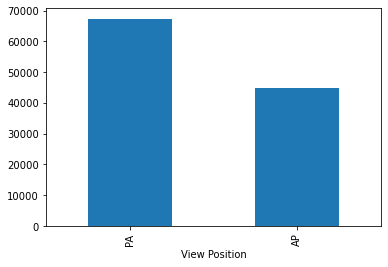

In [23]:
all_xray_df["View Position"].value_counts().plot.bar()
plt.xlabel("View Position");

> We have more PosteroAnterior (PA) views than AnteroPosterior (AP) view, that is more view taken from back to front.

#### Evaluating diseases and comorbidities

In [24]:
findings = list(set(all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).sum()))

In [25]:
findings

['Edema',
 'Hernia',
 'Pleural_Thickening',
 'Consolidation',
 'Effusion',
 'Emphysema',
 'Infiltration',
 'Pneumonia',
 'No Finding',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Fibrosis',
 'Cardiomegaly',
 'Pneumothorax']

In [26]:
diseases = findings.copy()
diseases.remove("No Finding")

In [27]:
other_diseases = diseases.copy()
other_diseases.remove("Pneumonia")

In [28]:
print("Cases of Pneumonia represent {:.1f}% of the people in this study.".format(len(pneumonia_df)/len(all_xray_df)*100))
print("Healthy subjects represent {:.1f}% of the people in this study.".format(len(all_xray_df[all_xray_df['Finding Labels']=='No Finding'])/len(all_xray_df)*100))
print("People who don't have Pneumonia but have another finding represent {:.1f}% of the people in this study.".format(100-len(all_xray_df[all_xray_df['Finding Labels']=='No Finding'])/len(all_xray_df)*100-len(pneumonia_df)/len(all_xray_df)*100))

Cases of Pneumonia represent 1.3% of the people in this study.
Healthy subjects represent 53.8% of the people in this study.
People who don't have Pneumonia but have another finding represent 44.9% of the people in this study.


> As said in the introduction, the prevalence of pneumonia may differ if we were to use only chest x-rays that were acquired in an ER setting with suspicion of Pneumonia. We can say it is **10%** for the purpose of creating our validation dataset (that is instead of 1.3%).

In [29]:
pd.set_option('mode.chained_assignment', None) # Disable warning SettingWithCopy
diseases_df = pd.DataFrame(index=all_xray_df.index)
diseases_df['Finding Labels'] = all_xray_df['Finding Labels'].copy()

for finding in diseases:
    diseases_df[finding] = diseases_df['Finding Labels'].map(lambda x: 1 if finding in x else 0)

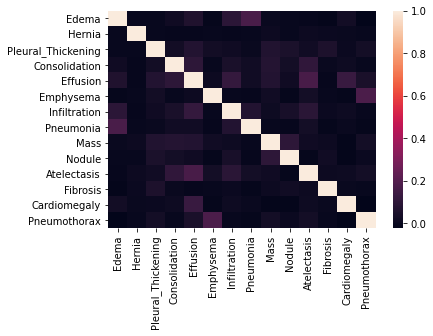

In [30]:
sns.heatmap(diseases_df[diseases].corr())

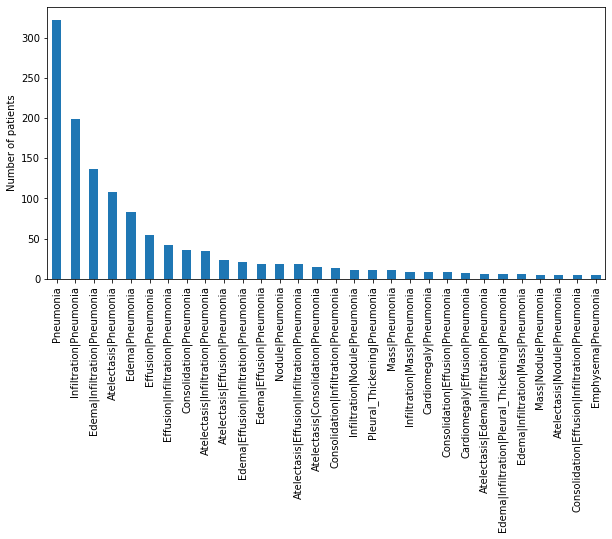

In [31]:
plt.figure(figsize=(10,5))
pneumonia_df['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.ylabel("Number of patients");

> Pneumonia is observed often with Infiltration and Edema.

In [32]:
np.round(pneumonia_df['Finding Labels'].value_counts()['Pneumonia']/len(pneumonia_df)*100)

23.0

In [33]:
np.round(pneumonia_df['Finding Labels'].value_counts()['Infiltration|Pneumonia']/len(pneumonia_df)*100)

14.0

In [34]:
np.round(pneumonia_df['Finding Labels'].value_counts()['Edema|Infiltration|Pneumonia']/len(pneumonia_df)*100)

10.0

> Almost 23% of patients with Pneumonia don't have comorbidities and around 14% of patients with Pneumonia also have Infiltration but no other disease. Around 10% of patients with Pneumonia have Infiltration and Edema but no other disease. 

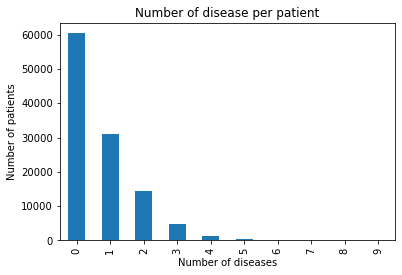

In [35]:
diseases_df[diseases].sum(axis=1).value_counts(sort=False).plot.bar()
plt.title("Number of disease per patient")
plt.xlabel("Number of diseases")
plt.ylabel("Number of patients");

## Exploring the pixel-level data
***

Let's work on a smaller subset of the data.

In [36]:
print("We have {} samples.".format(len(sample_df)))

We have 5606 samples.


In [37]:
sample_df.sample(random_state=2021)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2412,00012134_002.png,No Finding,2,12134,025Y,M,AP,2500,2048,0.168,0.168


Each entry has the corresponding image path in the column `Image Index`. We can write a function that takes the path and plots the image and the corresponding histogram.

In [38]:
def plot_image_histogram(path):
    image = io.imread(path)
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(1, 2, 1)
    plt.title('Image: '+path)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    
    plt.subplot(1, 2, 2)
    plt.title('Histogram')
    plt.hist(image.flatten(), bins=256, range=(0,256))

We just need to look where the files are stored.

In [39]:
!pwd

/home/workspace


In [40]:
!ls

'Build and train model.ipynb'   test3.dcm
 EDA.ipynb		        test4.dcm
 FDA_Submission.pdf	        test5.dcm
 FDA_Submission_Template.md     test6.dcm
 Inference.ipynb	        xray_class_best_model.json
 sample_labels.csv	        xray_class_best_model_weights.hdf5
 test1.dcm		        xray_class_best_threshold.npz
 test2.dcm


In [41]:
!ls /data

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


In [42]:
!ls /data/images_001

images


In [43]:
!ls /data/images_001/images/*34_002.png

/data/images_001/images/00000334_002.png
/data/images_001/images/00000634_002.png
/data/images_001/images/00001034_002.png
/data/images_001/images/00001334_002.png


In [44]:
path_dict = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

Let's visualize X-rays from healthy subjects.

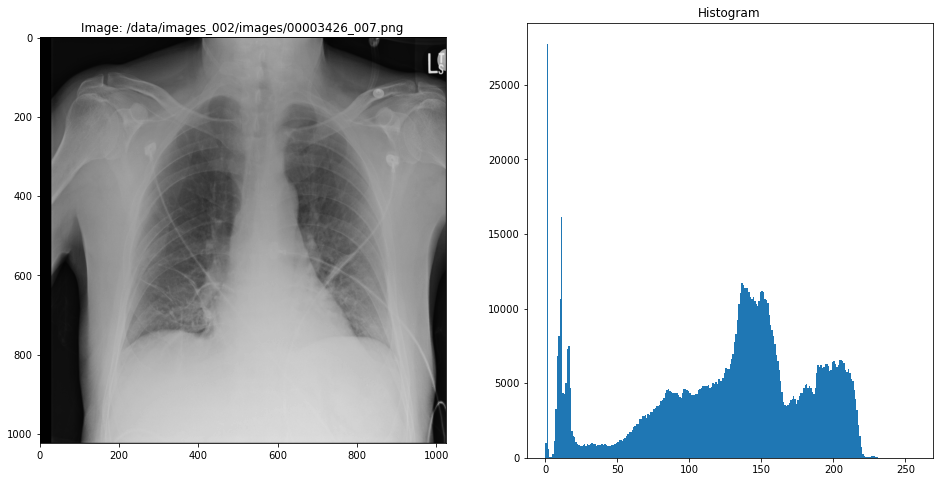

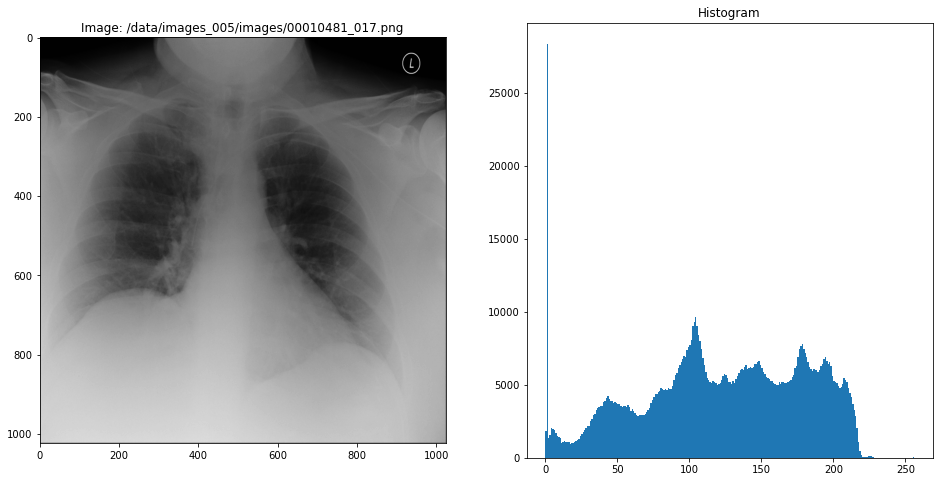

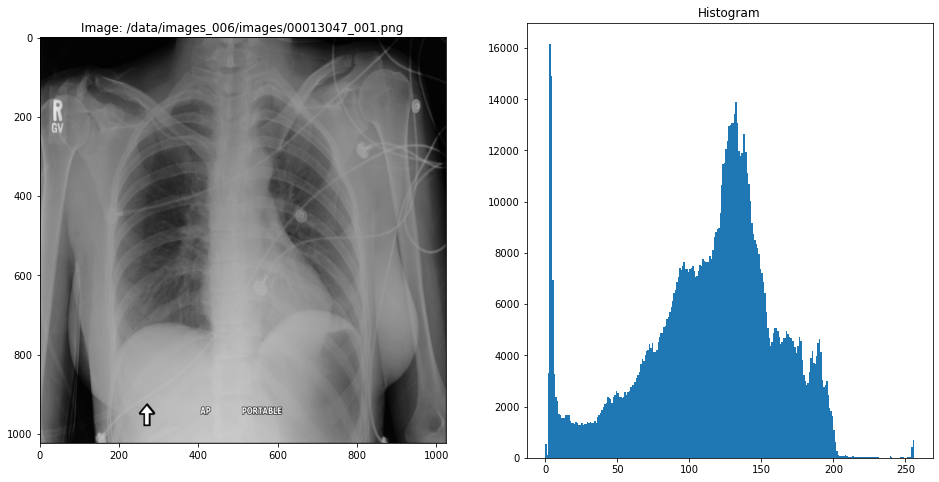

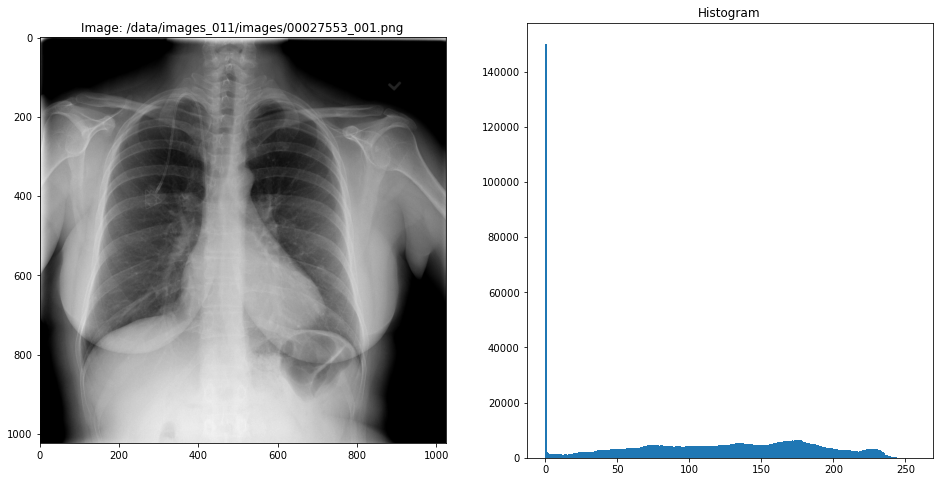

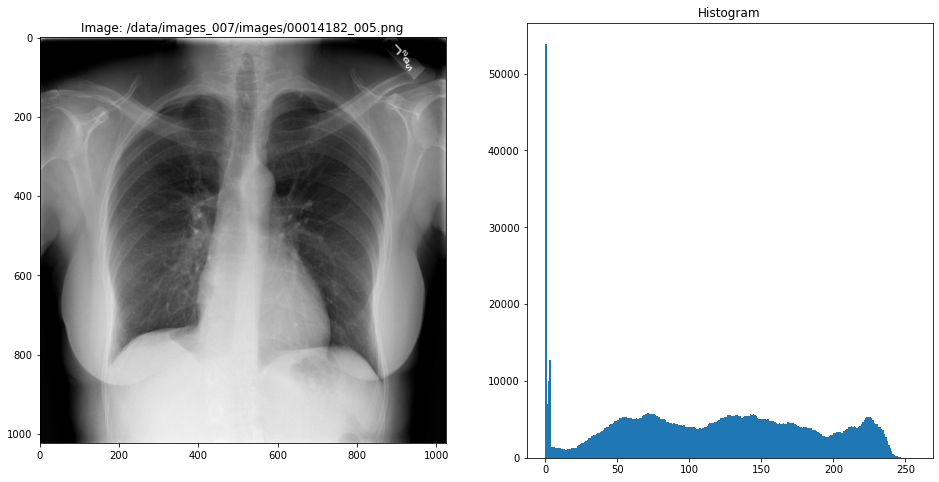

In [45]:
names = sample_df[sample_df['Finding Labels']=='No Finding']['Image Index'].sample(5, random_state=2021)
for name in names:
    plot_image_histogram(path_dict[name])

> A sharp peak corresponding to the black background appears in the histogram.

Let's visualize X-rays from patients who have Pneumonia.

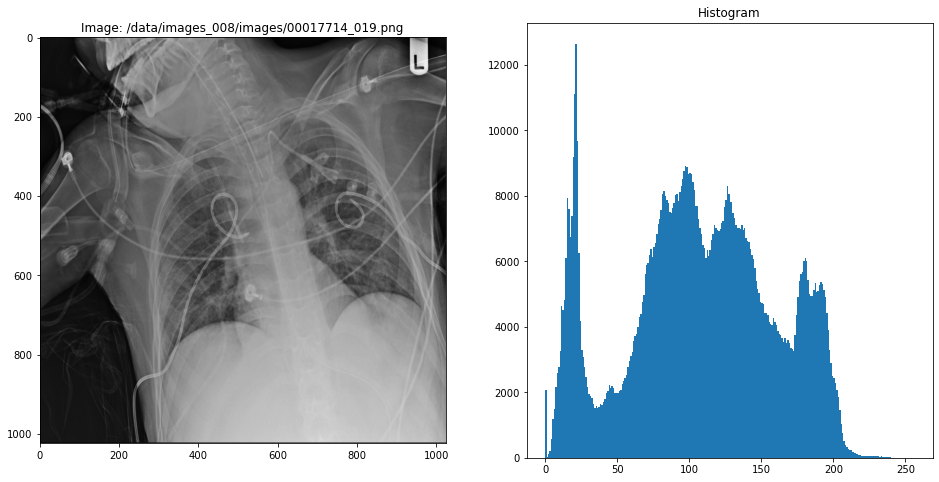

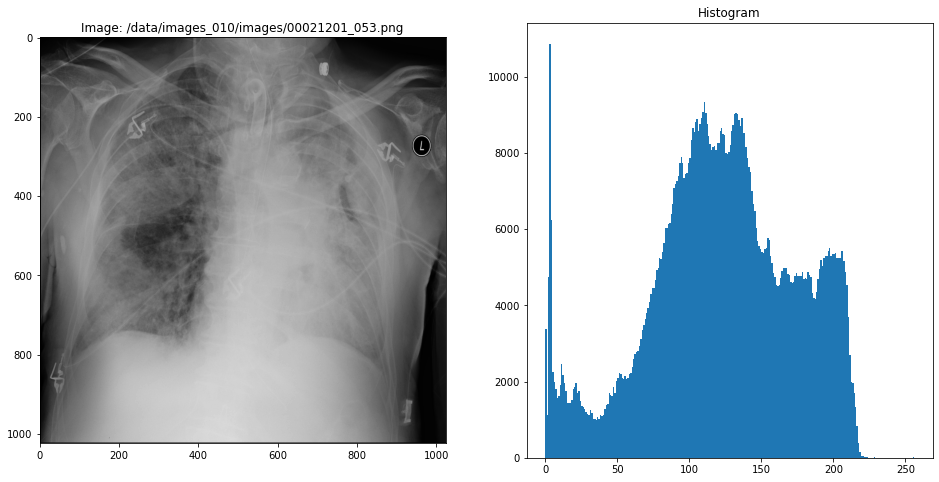

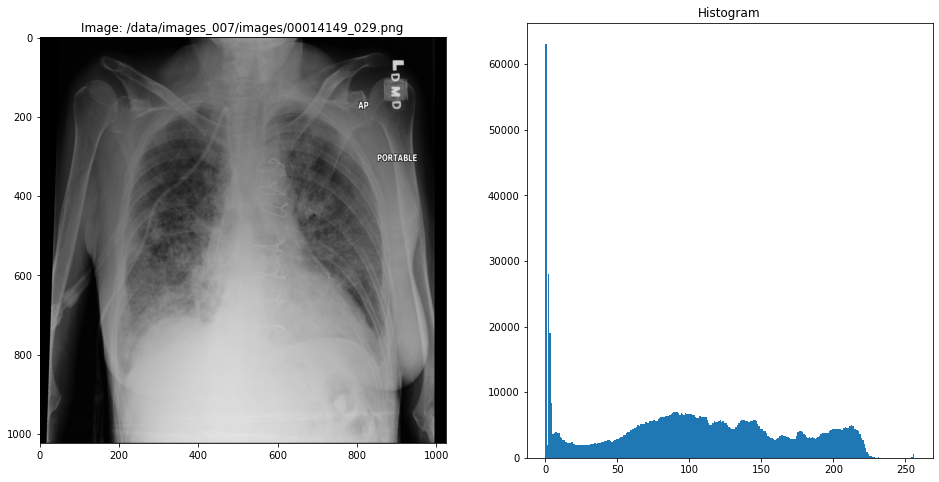

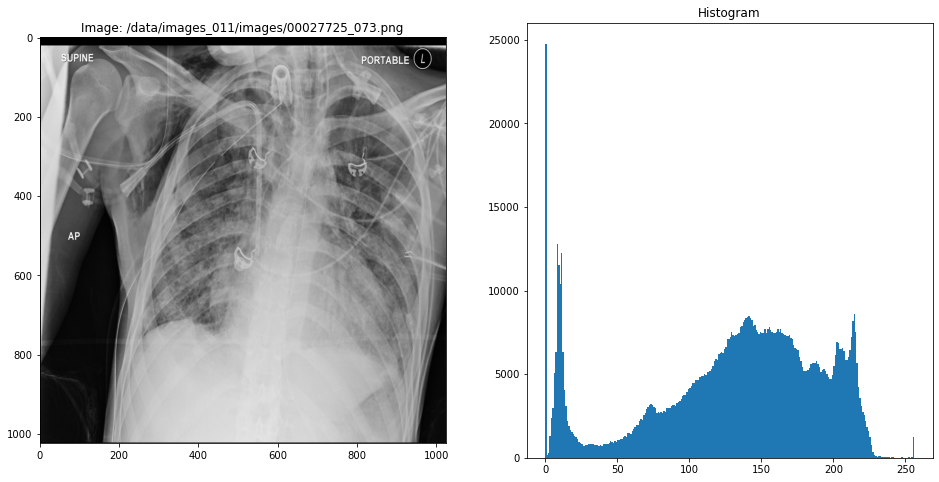

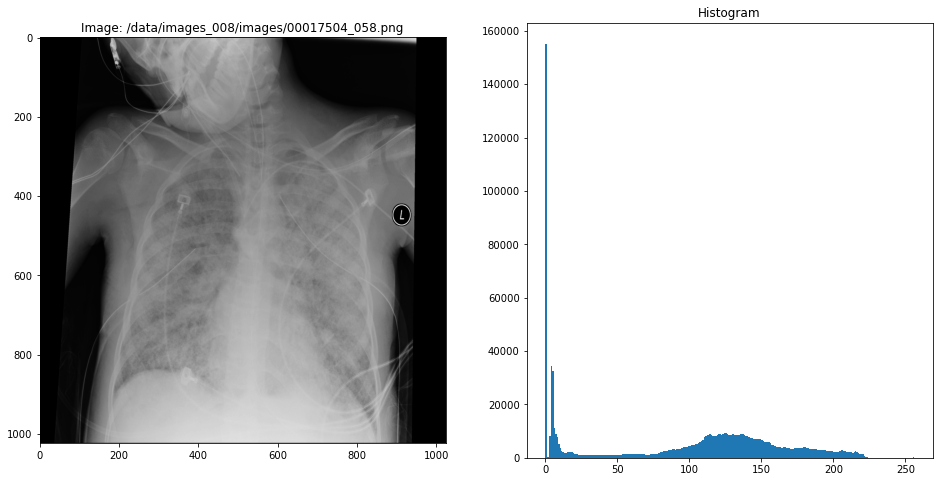

In [46]:
names = sample_df[sample_df['Finding Labels'].apply(lambda x: 'Pneumonia' in x.split('|'))==1]['Image Index'].sample(5, random_state=2021)
for name in names:
    plot_image_histogram(path_dict[name])

Let's compare one X-ray from a healthy person and an X-ray from a person with Pneumonia.

Healthy subject
Patient with Pneumonia


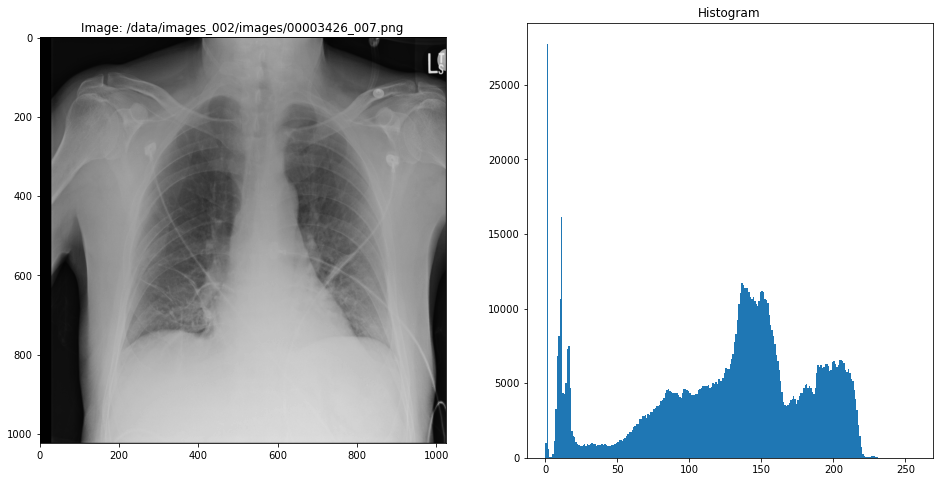

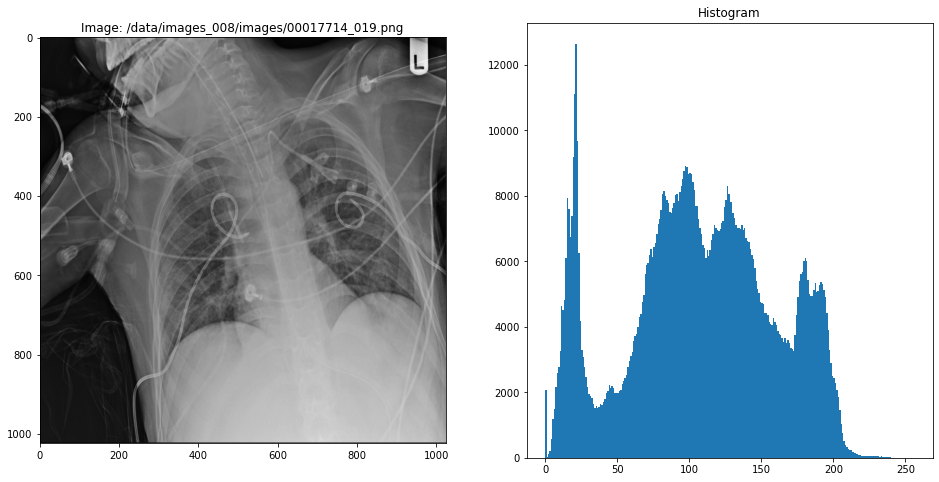

In [47]:
name = sample_df[sample_df['Finding Labels']=='No Finding']['Image Index'].sample(random_state=2021).item()
print('Healthy subject')
plot_image_histogram(path_dict[name])

name = sample_df[sample_df['Finding Labels'].apply(lambda x: 'Pneumonia' in x.split('|'))==1]['Image Index'].sample(random_state=2021).item()
print('Patient with Pneumonia')
plot_image_histogram(path_dict[name])

> The histograms of healthy and sick subjects don't differ greatly. We get multimodal distributions and we don't directly see discriminant characteristics between the two classes. An example of a discriminant characteristic would be a peak recurring in  all the images from the same class and in the same location.     
On the original images, we see that the soft tissue and the bones appear white/light gray and the lungs appear black/dark gray. Both classes look the same for an untrained eye.  
Another thing to note is that the distribution of pixel intensity differs considerably within the same class. This is because the images were acquired in different condition: the radiation dose used can vary, the patient posture can also change, etc.


Let's visualize X-rays from patients who have Infiltration and Atelectasis.

Patient with Infiltration


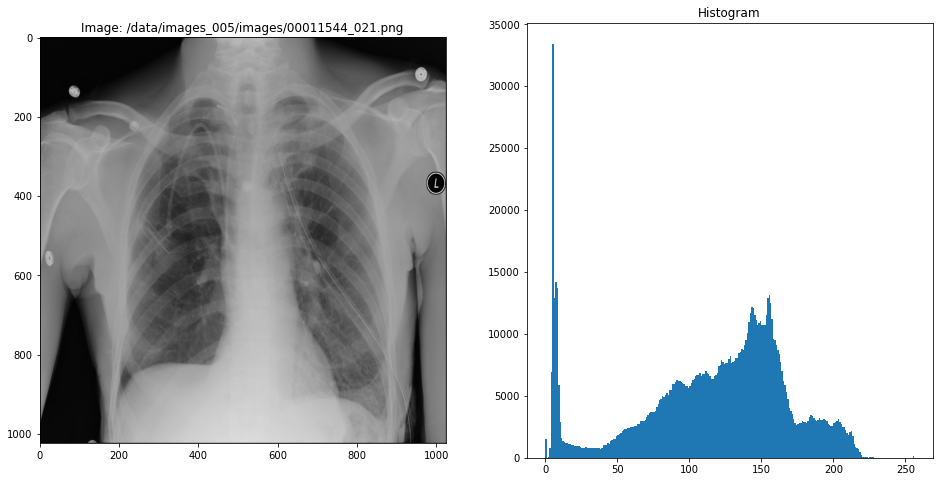

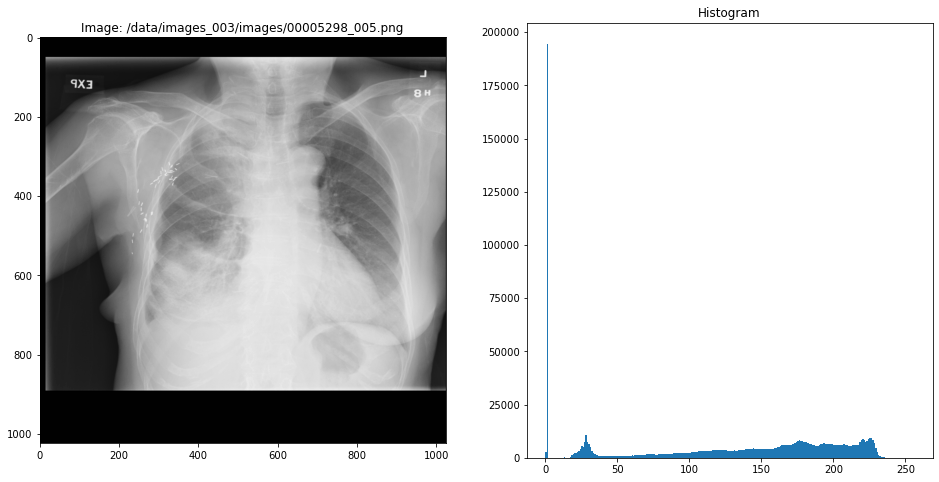

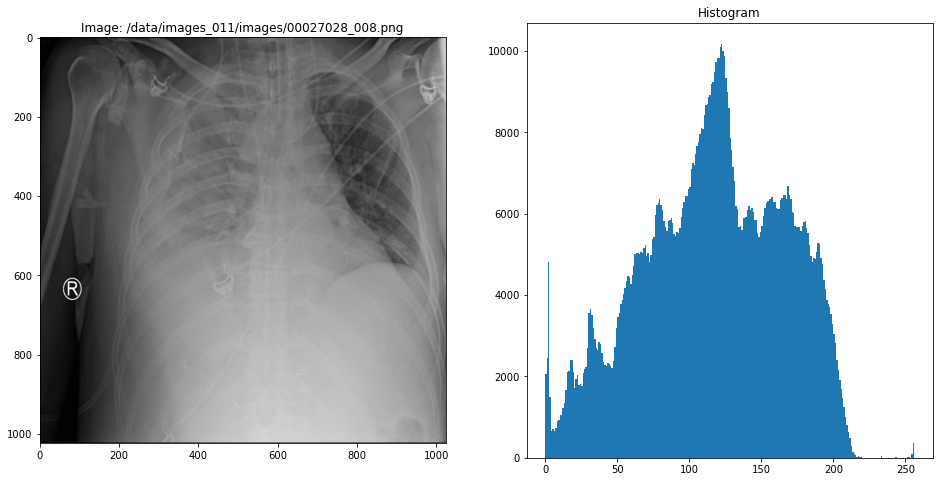

In [48]:
print('Patient with Infiltration')
names = sample_df[sample_df['Finding Labels'].apply(lambda x: ('Infiltration' in x.split('|'))&~('Pneumonia' in x.split('|')))==1]['Image Index'].sample(3, random_state=2021)
for name in names:
    plot_image_histogram(path_dict[name])

Patient with Atelectasis


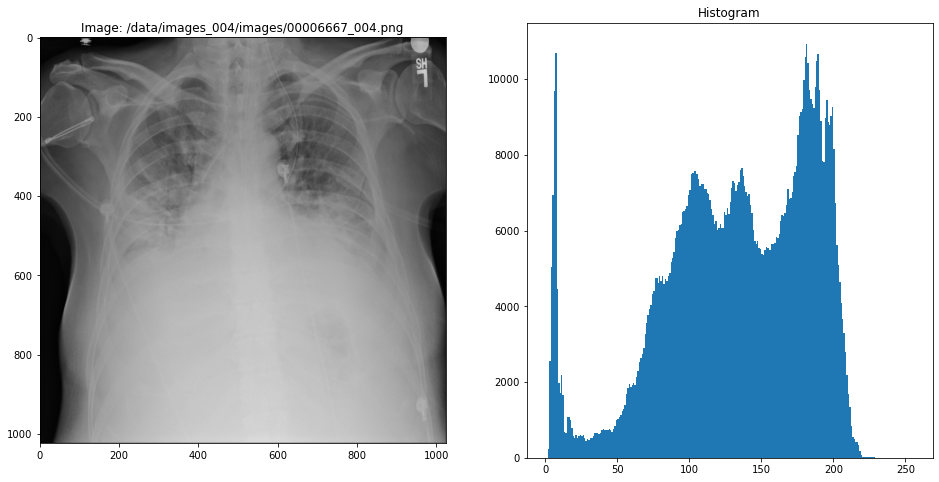

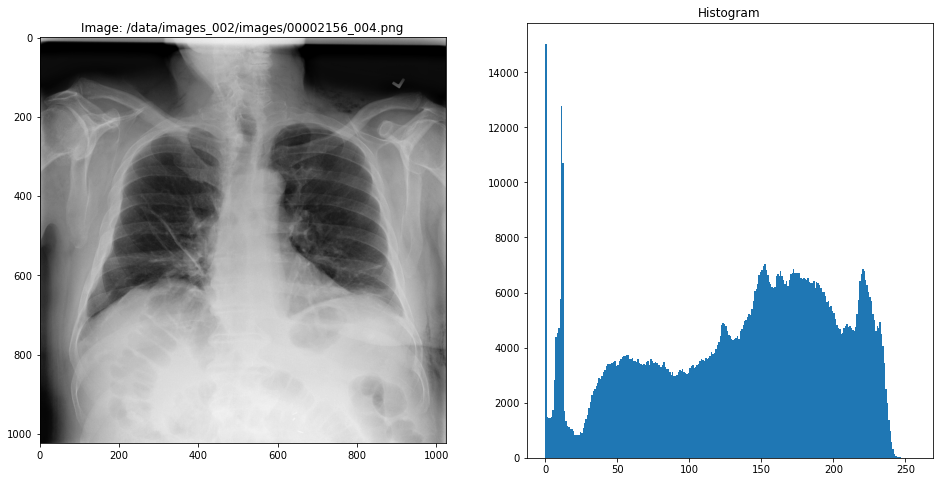

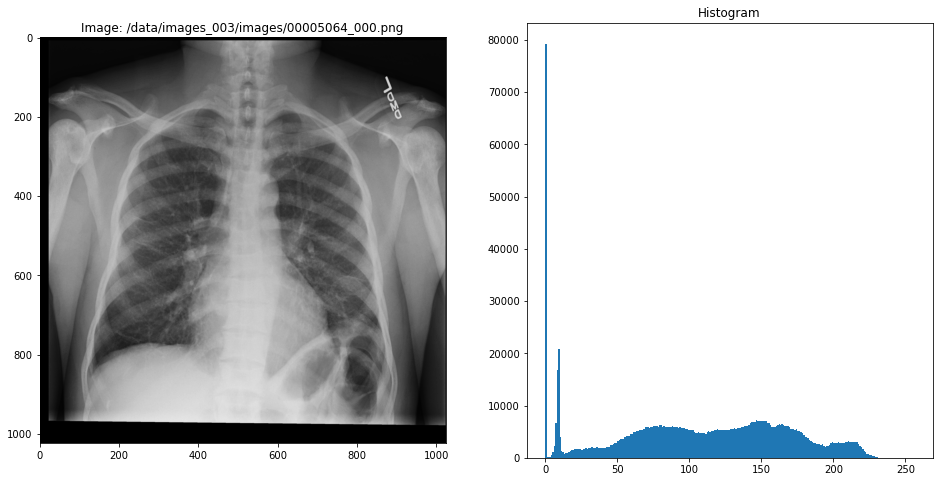

In [49]:
print('Patient with Atelectasis')
names = sample_df[sample_df['Finding Labels'].apply(lambda x: ('Atelectasis' in x.split('|'))&~('Pneumonia' in x.split('|')))==1]['Image Index'].sample(3, random_state=2021)
for name in names:
    plot_image_histogram(path_dict[name])

> Again, it is difficult for an untrained eye to differentiate between these diseases. The histograms don't help in this task either, since some distributions are similar but correspond to different classes.

## Conclusion
***
Given the nature of the data, we see that it is difficult to classify the images using only the histogram. We need information from the neighbouring pixels. That's why we will be using a CNN to perform the classification.